In [37]:
import torch
import sys, os
import numpy as np
sys.path.append('../')
from loader.MNIST_dataset import MNIST
from models import load_pretrained
from loader import get_dataloader
from geometry import get_pullbacked_Riemannian_metric
import matplotlib.pyplot as plt
from utils.utils import label_to_color, figure_to_array, PD_metric_to_ellipse
device = f'cuda:0'

In [57]:
# # MNIST digits 0, 1
# vae, cfg = load_pretrained(
#     identifier='MNIST/DIM_2/vae_mnist_01',
#     config_file='mnist_vae_z2.yml',
#     ckpt_file='model_best.pkl',
#     root='../results'
# )
# irvae, cfg = load_pretrained(
#     identifier='MNIST/DIM_2/irvae_mnist_01',
#     config_file='mnist_irvae_z2.yml',
#     ckpt_file='model_best.pkl',
#     root='../results'
# )

# MNIST digits 0, 1, 5
vae, cfg = load_pretrained(
    identifier='MNIST/DIM_2/vae_mnist_015',
    config_file='mnist_vae_z2.yml',
    ckpt_file='model_best.pkl',
    root='../results'
)
irvae, cfg = load_pretrained(
    identifier='MNIST/DIM_2/irvae_mnist_015',
    config_file='mnist_irvae_z2.yml',
    ckpt_file='model_best.pkl',
    root='../results'
)

vae.to(device);
irvae.to(device);

In [58]:
val_data_cfg = cfg['data']['validation']
val_data_cfg['root'] = '../dataset'
dl = get_dataloader(val_data_cfg)

MNIST split validation | torch.Size([3013, 1, 28, 28])


In [59]:
num_points_for_each_class = 200
num_G_plots_for_each_class = 10
label_unique = torch.unique(dl.dataset.targets)
z_ = []
z_sampled_ = []
label_ = []
label_sampled_ = []
G_ = []
for label in label_unique:
    temp_data = dl.dataset.data[dl.dataset.targets == label][:num_points_for_each_class]
    temp_z = vae.encode(temp_data.to(device))
    z_sampled = temp_z[torch.randperm(len(temp_z))[:num_G_plots_for_each_class]]
    G = get_pullbacked_Riemannian_metric(vae.decode, z_sampled)

    z_.append(temp_z)
    label_.append(label.repeat(temp_z.size(0)))
    z_sampled_.append(z_sampled)
    label_sampled_.append(label.repeat(z_sampled.size(0)))
    G_.append(G)


vae_z_ = torch.cat(z_, dim=0).detach().cpu().numpy()
vae_label_ = torch.cat(label_, dim=0).detach().cpu().numpy()
vae_color_ = label_to_color(vae_label_)
vae_G_ = torch.cat(G_, dim=0).detach().cpu()
vae_z_sampled_ = torch.cat(z_sampled_, dim=0).detach().cpu().numpy()
vae_label_sampled_ = torch.cat(label_sampled_, dim=0).detach().cpu().numpy()
vae_color_sampled_ = label_to_color(vae_label_sampled_)

z_ = []
z_sampled_ = []
label_ = []
label_sampled_ = []
G_ = []
for label in label_unique:
    temp_data = dl.dataset.data[dl.dataset.targets == label][:num_points_for_each_class]
    temp_z = irvae.encode(temp_data.to(device))
    z_sampled = temp_z[torch.randperm(len(temp_z))[:num_G_plots_for_each_class]]
    G = get_pullbacked_Riemannian_metric(irvae.decode, z_sampled)

    z_.append(temp_z)
    label_.append(label.repeat(temp_z.size(0)))
    z_sampled_.append(z_sampled)
    label_sampled_.append(label.repeat(z_sampled.size(0)))
    G_.append(G)


irvae_z_ = torch.cat(z_, dim=0).detach().cpu().numpy()
irvae_label_ = torch.cat(label_, dim=0).detach().cpu().numpy()
irvae_color_ = label_to_color(irvae_label_)
irvae_G_ = torch.cat(G_, dim=0).detach().cpu()
irvae_z_sampled_ = torch.cat(z_sampled_, dim=0).detach().cpu().numpy()
irvae_label_sampled_ = torch.cat(label_sampled_, dim=0).detach().cpu().numpy()
irvae_color_sampled_ = label_to_color(irvae_label_sampled_)

In [60]:
plt.rc('font', size=12)
index = cfg['data']['training']['digits'].split('_')[1]

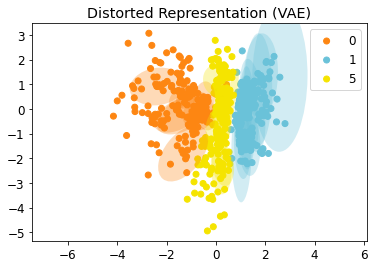

In [61]:
f = plt.figure()
z_scale = np.minimum(np.max(vae_z_, axis=0), np.min(vae_z_, axis=0))
eig_mean = torch.svd(vae_G_).S.mean().item()
scale = 0.1 * z_scale * np.sqrt(eig_mean)
alpha = 0.3
for idx in range(len(vae_z_sampled_)):
    e = PD_metric_to_ellipse(np.linalg.inv(vae_G_[idx,:,:]), vae_z_sampled_[idx,:], scale, fc=vae_color_sampled_[idx,:]/255.0, alpha=alpha)
    plt.gca().add_artist(e)
for label in label_unique:
    label = label.item()
    plt.scatter(vae_z_[vae_label_==label,0], vae_z_[vae_label_==label,1], c=vae_color_[vae_label_==label]/255, label=label)
plt.legend()
plt.axis('equal')
plt.title('Distorted Representation (VAE)')
plt.savefig(f'../figure/vae{index}.png')
plt.show()

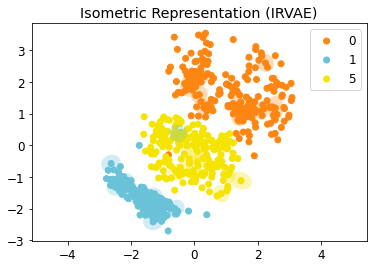

In [62]:
f = plt.figure()
z_scale = np.minimum(np.max(irvae_z_, axis=0), np.min(irvae_z_, axis=0))
eig_mean = torch.svd(irvae_G_).S.mean().item()
scale = 0.1 * z_scale * np.sqrt(eig_mean)
alpha = 0.3
for idx in range(len(irvae_z_sampled_)):
    e = PD_metric_to_ellipse(np.linalg.inv(irvae_G_[idx,:,:]), irvae_z_sampled_[idx,:], scale, fc=irvae_color_sampled_[idx,:]/255.0, alpha=alpha)
    plt.gca().add_artist(e)
for label in label_unique:
    label = label.item()
    plt.scatter(irvae_z_[irvae_label_==label,0], irvae_z_[irvae_label_==label,1], c=irvae_color_[irvae_label_==label]/255, label=label)
plt.legend()
plt.axis('equal')
plt.title('Isometric Representation (IRVAE)')
plt.savefig(f'../figure/irvae{index}.png')
plt.show()